In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from environment import run_experiment, RunParameters, RunStatistics
from baifg.model.feedback_graph import FeedbackGraph
from baifg.model.reward_model import GaussianRewardModel, RewardType
from baifg.algorithms.eps_greedy import EpsilonGreedy, EpsilonGreedyParameters
from baifg.algorithms.ucb import UCB
from baifg.algorithms.base.graph_estimator import GraphEstimator
from baifg.algorithms.base.base_algorithm import BaseAlg
from baifg.utils.graphs import make_loopless_clique
from itertools import product
from typing import List, NamedTuple
from tqdm import tqdm

def make_model(algo_name: BaseAlg, algo_params: NamedTuple, K: int, fg: FeedbackGraph, delta: float, informed: bool) -> BaseAlg:
    if algo_name == EpsilonGreedy:
        return EpsilonGreedy(
            GraphEstimator.optimistic_graph(K, informed=informed, known=False),
            fg.reward_model.reward_type,
            delta=delta,
            parameters=algo_params)
    elif algo_name == UCB:
        return UCB(
            GraphEstimator.optimistic_graph(K, informed=informed, known=False),
            reward_type=fg.reward_model.reward_type,
            delta=delta)
    raise Exception('Algorithm not found')



In [13]:
envs: List[RunParameters] = []
Kvalues = [5]
delta = np.exp(-np.linspace(2,6,5))

for K, delta, informed in product(Kvalues, delta, [False]):
    envs.append(
        RunParameters('Loopless clique', f'p=0.5, K={K}, delta={delta}, informed={informed}', delta, informed=True,
                      known=False, fg=make_loopless_clique(p=0.5, mu=np.linspace(0, 1, K)),
                      results = {})
    )

algorithms = [
    (EpsilonGreedy, EpsilonGreedyParameters(exp_rate=0.3, information_greedy=False)),
    (EpsilonGreedy, EpsilonGreedyParameters(exp_rate=0.3, information_greedy=True)),
    (UCB, None)]


In [14]:

Nsims = 10

df = pd.DataFrame({},  columns =  ["env", "K", "seed", "algorithm", "delta", "stopping_time", "identified_optimal_arm"])

for env in envs:
    print(f'Running {env.name} - {env.description}')
    for n in tqdm(range(Nsims)):
        for algo, algo_params in algorithms:
            algo = make_model(algo_name=algo, algo_params=algo_params,
                              K=env.fg.K, fg=env.fg, delta=env.delta, informed=env.informed)
            results = run_experiment(fg=env.fg, algo=algo, seed=n)

            if algo.NAME not in env.results:
                env.results[algo.NAME] = []
            env.results[algo.NAME].append(results)

            df.loc[len(df.index)] = [
                env.name, env.fg.K, n, algo.NAME, env.delta, results.stopping_time, 
                results.estimated_best_vertex == env.fg.reward_model.astar]


Running Loopless clique - p=0.5, K=5, delta=0.1353352832366127, informed=False


100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


Running Loopless clique - p=0.5, K=5, delta=0.049787068367863944, informed=False


100%|██████████| 10/10 [00:23<00:00,  2.33s/it]


Running Loopless clique - p=0.5, K=5, delta=0.01831563888873418, informed=False


100%|██████████| 10/10 [00:37<00:00,  3.78s/it]


Running Loopless clique - p=0.5, K=5, delta=0.006737946999085467, informed=False


100%|██████████| 10/10 [00:44<00:00,  4.45s/it]


Running Loopless clique - p=0.5, K=5, delta=0.0024787521766663585, informed=False


100%|██████████| 10/10 [00:57<00:00,  5.76s/it]


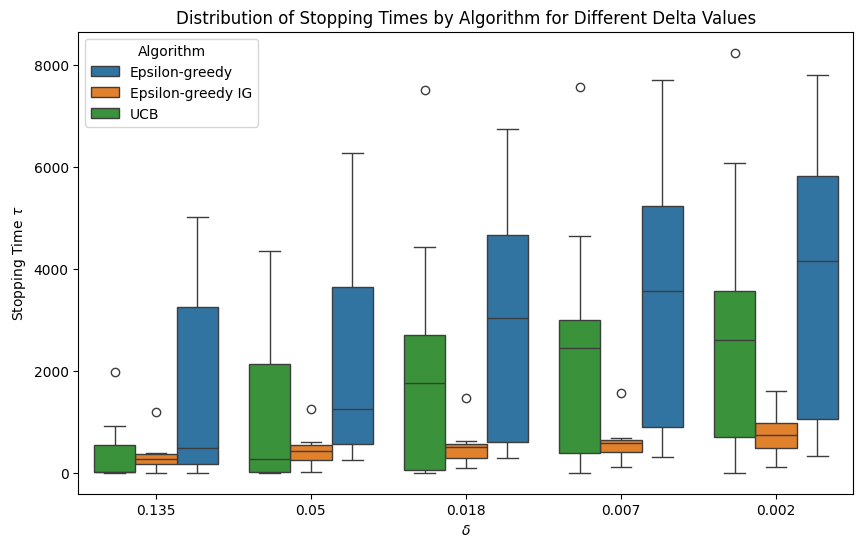

In [15]:


# Filter the DataFrame for a given environment, e.g., "Loopless clique"
filtered_df = df[df['env'] == 'Loopless clique']
filtered_df['delta'] = filtered_df['delta'].round(3)
# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='delta', y='stopping_time', hue='algorithm', data=filtered_df)

# Customize labels
plt.xlabel(r'$\delta$')
plt.ylabel(r'Stopping Time $\tau$')
plt.title('Distribution of Stopping Times by Algorithm for Different Delta Values')
plt.legend(title='Algorithm')
plt.gca().invert_xaxis()

# Display the plot
plt.show()

In [12]:
df

,env,K,seed,algorithm,delta,stopping_time,identified_optimal_arm
0,Loopless clique,6,0,Epsilon-greedy,0.135335,921,True
1,Loopless clique,6,0,Epsilon-greedy IG,0.135335,2595,True
2,Loopless clique,6,0,UCB,0.135335,57,True
3,Loopless clique,6,1,Epsilon-greedy,0.135335,53,True
4,Loopless clique,6,1,Epsilon-greedy IG,0.135335,551,True
...,...,...,...,...,...,...,...
145,Loopless clique,6,8,Epsilon-greedy IG,0.002479,10398,True
146,Loopless clique,6,8,UCB,0.002479,15,False
147,Loopless clique,6,9,Epsilon-greedy,0.002479,737,True
148,Loopless clique,6,9,Epsilon-greedy IG,0.002479,10767,True


In [ ]:
df

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(8,4))
for env in envs:
    for key in env.results.keys():
        [res.stopping_time for res in env.results[key]]

[RunStatistics(estimated_best_vertex=np.int64(4), stopping_time=374), RunStatistics(estimated_best_vertex=np.int64(4), stopping_time=284), RunStatistics(estimated_best_vertex=np.int64(4), stopping_time=171), RunStatistics(estimated_best_vertex=np.int64(4), stopping_time=131), RunStatistics(estimated_best_vertex=np.int64(4), stopping_time=8), RunStatistics(estimated_best_vertex=np.int64(4), stopping_time=18), RunStatistics(estimated_best_vertex=np.int64(4), stopping_time=3975), RunStatistics(estimated_best_vertex=np.int64(4), stopping_time=7), RunStatistics(estimated_best_vertex=np.int64(4), stopping_time=205), RunStatistics(estimated_best_vertex=np.int64(4), stopping_time=214)]
[RunStatistics(estimated_best_vertex=np.int64(1), stopping_time=6), RunStatistics(estimated_best_vertex=np.int64(4), stopping_time=359), RunStatistics(estimated_best_vertex=np.int64(4), stopping_time=16), RunStatistics(estimated_best_vertex=np.int64(4), stopping_time=6), RunStatistics(estimated_best_vertex=np.in

In [5]:
print(algo.graph.N)
# print(algo.graph.Npair)
# print(algo.reward.M)
# print(algo.reward.mu)
print(algo.graph.G)
algo.reward.confidence

m = (algo.reward.mu + algo.reward.confidence).argmax()
algo.graph.G[:,m]

algo.graph.confidence


[7268.   56.   43.   32.   26.   26.   29.   26.   32.   20.]
[[1.37589433e-04 4.93258118e-01 4.91607045e-01 5.00000000e-01
  5.03439736e-01 4.98761695e-01 4.91331866e-01 4.95321959e-01
  4.97660980e-01 5.08392955e-01]
 [8.39285714e-01 1.78571429e-02 6.96428571e-01 2.32142857e-01
  8.21428571e-01 2.85714286e-01 7.32142857e-01 2.50000000e-01
  7.50000000e-01 2.50000000e-01]
 [9.06976744e-01 2.09302326e-01 2.32558140e-02 2.09302326e-01
  8.13953488e-01 2.32558140e-01 9.06976744e-01 2.32558140e-01
  9.30232558e-01 2.09302326e-01]
 [8.12500000e-01 1.87500000e-01 9.37500000e-01 3.12500000e-02
  9.06250000e-01 1.87500000e-01 7.81250000e-01 2.18750000e-01
  9.37500000e-01 1.56250000e-01]
 [9.61538462e-01 2.30769231e-01 8.46153846e-01 2.30769231e-01
  3.84615385e-02 1.92307692e-01 8.46153846e-01 2.30769231e-01
  9.23076923e-01 1.15384615e-01]
 [9.61538462e-01 1.15384615e-01 9.61538462e-01 7.69230769e-02
  9.61538462e-01 3.84615385e-02 8.84615385e-01 7.69230769e-02
  9.23076923e-01 1.15384615e-

array([[0.0247865 , 0.0247865 , 0.0247865 , 0.0247865 , 0.0247865 ,
        0.0247865 , 0.0247865 , 0.0247865 , 0.0247865 , 0.0247865 ],
       [0.28237662, 0.28237662, 0.28237662, 0.28237662, 0.28237662,
        0.28237662, 0.28237662, 0.28237662, 0.28237662, 0.28237662],
       [0.32224673, 0.32224673, 0.32224673, 0.32224673, 0.32224673,
        0.32224673, 0.32224673, 0.32224673, 0.32224673, 0.32224673],
       [0.37354916, 0.37354916, 0.37354916, 0.37354916, 0.37354916,
        0.37354916, 0.37354916, 0.37354916, 0.37354916, 0.37354916],
       [0.41441558, 0.41441558, 0.41441558, 0.41441558, 0.41441558,
        0.41441558, 0.41441558, 0.41441558, 0.41441558, 0.41441558],
       [0.41441558, 0.41441558, 0.41441558, 0.41441558, 0.41441558,
        0.41441558, 0.41441558, 0.41441558, 0.41441558, 0.41441558],
       [0.39239526, 0.39239526, 0.39239526, 0.39239526, 0.39239526,
        0.39239526, 0.39239526, 0.39239526, 0.39239526, 0.39239526],
       [0.41441558, 0.41441558, 0.4144155